In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
total = pd.read_csv("../CSV/train_data.csv")
test = pd.read_csv("../CSV/pred_test.csv")

print("total shape : {}, test shape : {}".format(total.shape, test.shape))

total shape : (368088, 12), test shape : (15120, 12)


In [3]:
total.head(3)

,연월일,시간,일시,year,month,day,hour,weekday,구분,구분_int,공급량,기온(°C)
0,2013-01-01,1,2013-01-01 00:00:00,2013,1,1,0,1,A,0,2497.129,-8.3
1,2013-01-01,2,2013-01-01 01:00:00,2013,1,1,1,1,A,0,2363.265,-8.5
2,2013-01-01,3,2013-01-01 02:00:00,2013,1,1,2,1,A,0,2258.505,-8.4


In [4]:
def nmae(true_df, pred_df):
    target_idx = true_df.iloc[:,0]
    pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
    pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
    true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    
    true = true_df.iloc[:,1].to_numpy()
    pred = pred_df.iloc[:,1].to_numpy()
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [5]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

# "year", "month", "day", "hour", "weekday", "구분_int", "기온(°C)"
features = ["month", "hour", "구분_int", "기온(°C)"]
# features = ["year", "month", "day", "hour", "weekday", "구분_int", "기온(°C)"]
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

X = total[features]
y = total["공급량"]

In [6]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

# kfold = KFold(n_splits = 10, shuffle = True, random_state = 27)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42, 
    "learning_rate" : 0.1, 
    "max_depth" : 17
}

model = lgb.train(params, d_train, 1000, d_val, verbose_eval=20, early_stopping_rounds=10)

pred = model.predict(val_x)

true_y = pd.DataFrame({"y" : val_y})
pred_y = pd.DataFrame({"pred_y" : pred})

true_y.reset_index(drop = True, inplace = True)
true_y.reset_index(inplace = True)
pred_y.reset_index(inplace = True)

# cross_score = cross_val_score(model, X, y, cv = 3)

train_mse = mean_squared_error(val_y, pred)
print("MSE :", train_mse)
print("NMAE : {:.6f}".format(nmae(true_y, pred_y)))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 934.864036
Training until validation scores don't improve for 10 rounds


/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l1: 200.324
[40]	valid_0's l1: 133.276
[60]	valid_0's l1: 120.275
[80]	valid_0's l1: 116.56
[100]	valid_0's l1: 114.971
[120]	valid_0's l1: 113.819
[140]	valid_0's l1: 113.228
[160]	valid_0's l1: 112.687
[180]	valid_0's l1: 112.323
[200]	valid_0's l1: 111.993
[220]	valid_0's l1: 111.874
[240]	valid_0's l1: 111.65
[260]	valid_0's l1: 111.508
[280]	valid_0's l1: 111.42
[300]	valid_0's l1: 111.33
[320]	valid_0's l1: 111.264
[340]	valid_0's l1: 111.219
Early stopping, best iteration is:
[347]	valid_0's l1: 111.155
MSE : 32672.970726754054
NMAE : 0.533803


In [7]:
submission = pd.read_csv('../CSV/가스공급량 수요예측 모델개발 data/sample_submission.csv')

In [8]:
test_x = test[features]
preds = model.predict(test_x)
submission['공급량'] = preds
# submission.to_csv("../CSV/Submission/09_4_features_lightgbm_model.csv", index = False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44396 missing from current font.
  

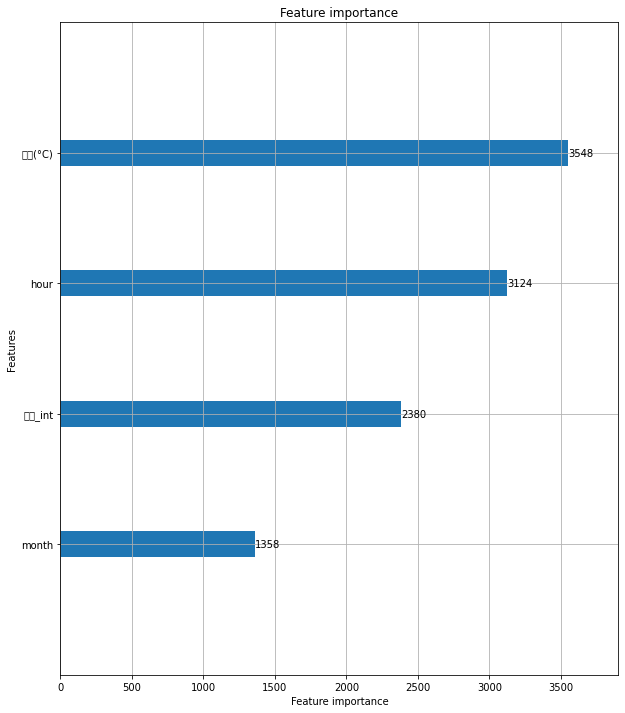

In [9]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(model, ax = ax)

In [10]:
true_y

,index,y
0,0,1765.008
1,1,1679.186
2,2,1610.885
3,3,1604.123
4,4,1711.506
...,...,...
61315,61315,681.033
61316,61316,669.961
61317,61317,657.941
61318,61318,610.953


In [11]:
pred_y

,index,pred_y
0,0,1975.068898
1,1,1745.654639
2,2,1636.263127
3,3,1658.083826
4,4,1826.752394
...,...,...
61315,61315,624.314130
61316,61316,629.675477
61317,61317,612.118598
61318,61318,561.009407
